In [1]:
import os
import re

import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import pandana as pdna

from pathlib import Path
from shapely.plotting import plot_polygon

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
census_path = Path(os.environ["CENSUS_PATH"])
data_path = Path(os.environ["DATA_PATH"])
framework_path = Path(os.environ["FRAMEWORK_PATH"])
denue_path = Path(os.environ["DENUE_PATH"])
population_grids_path = Path(os.environ["GRID_PATH"]) / "final"

In [3]:
lims = gpd.read_file(data_path / "lim_aumxl24/lim_aumxl24.shp").to_crs("EPSG:6372")["geometry"].item()
# lims = gpd.read_file(framework_path / "2020" / "02_bajacalifornia" / "02mun.shp").query("NOMGEO == 'Mexicali'")["geometry"].to_crs("EPSG:6372").item()

# Census

In [4]:
agebs = gpd.read_file(population_grids_path / "framework/agebs/2020.gpkg").set_index("CVEGEO").to_crs("EPSG:6372")
agebs = agebs.loc[agebs.intersects(lims), "geometry"]

In [5]:
df_census = (
    pd.read_csv(
        census_path / f"02.csv",
        usecols=[
            "ENTIDAD",
            "MUN",
            "LOC",
            "AGEB",
            "NOM_LOC",
            "VIVPAR_DES",
            "GRAPROES",
            "VIVTOT",
            "POBTOT",
            "VPH_INTER",
            "P_60YMAS"
        ],
        na_values=["*", "N/D"],
        dtype={
            "GRAPROES": float,
            "VIVTOT": float,
            "VIVPAR_DES": float,
            "POBTOT": float
        }
    )
    .assign(
        frac_viv_deshab=lambda x: x.VIVPAR_DES / x.VIVTOT,
        frac_viv_inter=lambda x: x.VPH_INTER / x.VIVTOT,
        CVEGEO=lambda x: (
            x.ENTIDAD.astype(str).str.rjust(2, "0")
            + x.MUN.astype(str).str.rjust(3, "0")
            + x.LOC.astype(str).str.rjust(4, "0")
            + x.AGEB.astype(str).str.rjust(4, "0")
        )
    )
    .set_index("CVEGEO")
    .query("NOM_LOC == 'Total AGEB urbana'")
    .drop(columns=[
        "VIVTOT",
        "VIVPAR_DES",
        "VPH_INTER",
        "ENTIDAD",
        "MUN",
        "LOC",
        "AGEB",
        "NOM_LOC"
    ])
    .join(agebs, how="inner")
)

df_census = (
    gpd.GeoDataFrame(df_census)
    .assign(
        pop_dens=lambda x: x.POBTOT / x.area * 1e6,
        over_60_frac=lambda x: x.P_60YMAS / x.POBTOT
    )
    .drop(columns=["P_60YMAS"])
)

# Amenities

In [6]:
def process_occupancy(x: str) -> str:
    matches = re.match(r'([0-9]+) a ([0-9]+) personas', x.strip())
    out = (int(matches.groups()[0]) + int(matches.groups()[1])) / 2 if matches else matches
    return out

In [7]:
SECTORS_MAP = [
    {"range": [(11, 11)], "sector": "primario"},
    {"range": [(21, 33)], "sector": "industria"},
    {"range": [(43, 46)], "sector": "comercio"},
    {"range": [(51, 56)], "sector": "oficina"},
    {"range": [(48, 49), (81, 81)], "sector": "servicios"},
    {"range": [(62, 62)], "sector": "salud"},
    {"range": [(61, 61)], "sector": "educacion"},
    {"range": [(72, 72)], "sector": "comercio"},
    {"range": [(73, 100)], "sector": "gubernamental"},
]

DENUE_TO_AMENITY_MAPPING = [
    # Salud
    {
        "name": "Consultorios médicos",
        "query": 'codigo_act.str.match("^621")',
    },
    {
        "name": "Hospital general",
        "query": 'codigo_act.str.match("^622")',
    },
    {
        "name": "Farmacia",
        "query": 'codigo_act.str.match("^46411")',
    },
    # Recreativo
    {
        "name": "Cine",
        "query": 'codigo_act.str.match("^51213")',
    },
    {
        "name": "Otros servicios recreativos",
        "query": 'codigo_act.str.match("^(71399|712|713)")',
    },
    {
        "name": "Clubs deportivos y de acondicionamiento físico",
        "query": 'codigo_act.str.match("^(71391|71394)")'

    },
    # Educación
    {
        "name": "Guarderia",
        "query": 'codigo_act.str.match("^6244")',
    },
    {
        "name": "Educación preescolar",
        "query": 'codigo_act.str.match("^61111")',
    },
    {
        "name": "Educación primaria",
        "query": 'codigo_act.str.match("^61112")'
    },
    {
        "name": "Educación secundaria",
        "query": 'codigo_act.str.match("^(61113|61114)")'
    },
    {
        "name": "Educación media superior",
        "query": 'codigo_act.str.match("^(61115|61116)")'
    },
    {
        "name": "Educación superior",
        "query": 'codigo_act.str.match("^(6112|6113)")'
    }
]

def map_sector_to_sector(codigo_act: int) -> str:
    for sector in SECTORS_MAP:
        for low, high in sector["range"]:
            if low <= codigo_act <= high:
                return sector["sector"]

## DENUE

In [8]:
denue_base = []
for subdir in denue_path.iterdir():
    temp_path = subdir / "conjunto_de_datos"
    if not temp_path.exists():
        continue

    for path in temp_path.glob("*.shp"):
        temp = gpd.read_file(path)
        denue_base.append(temp)

denue_base = pd.concat(denue_base, ignore_index=True).to_crs("EPSG:6372")
denue_base = denue_base[denue_base["geometry"].within(lims.buffer(5000))]

In [9]:
denue_amenities = (
    denue_base
    .assign(
        per_ocu=lambda df: df["per_ocu"].apply(process_occupancy),
        codigo_act=lambda df: df["codigo_act"].astype(str)
    )
    .dropna(subset=["per_ocu"])
    .rename(columns={"per_ocu": "num_workers"})
    [["geometry", "codigo_act", "num_workers"]]
)

for elem in DENUE_TO_AMENITY_MAPPING:
    idx = denue_amenities.query(elem["query"]).index
    denue_amenities.loc[idx, "amenity"] = elem["name"]

denue_amenities = (
    denue_amenities
    .dropna(subset=["amenity"])
    .drop(columns=["codigo_act"])
)

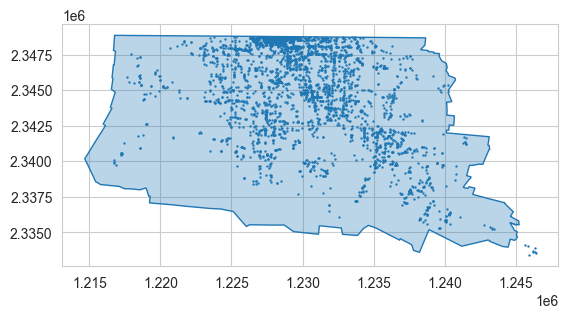

In [10]:
denue_amenities.plot(markersize=0.5)
plot_polygon(lims, add_points=False)

## Public spaces

In [11]:
public_amenities = (
    gpd.read_file(data_path / "esp_pub/esp_pub.shp")
    .to_crs("EPSG:6372")
    .assign(
        radius=lambda df: np.sqrt(df.Sup_M2 / np.pi),
        geometry=lambda df: df.apply(lambda x: x.geometry.buffer(x.radius, resolution=64), axis=1)
    )
    .assign(
        geometry=lambda x: x.geometry.centroid,
        amenity="Parques recreativos"
    )
    .rename(columns={"Sup_M2": "area"})
    [["amenity", "area", "geometry",]]
)

## All

In [12]:
amenities = pd.concat([denue_amenities, public_amenities], axis=0, ignore_index=True).to_crs("EPSG:6372")
amenities = amenities[amenities.within(lims.buffer(5000))]

In [13]:
amenities.to_file("./amenities.gpkg")

# Network

In [16]:
bounds_latlon = gpd.GeoSeries([lims], crs="EPSG:6372").to_crs("EPSG:4326").total_bounds

ox.settings.bidirectional_network_types = ["walk"]

g = ox.graph_from_bbox(bbox=bounds_latlon, network_type="drive")
g = ox.add_edge_speeds(g)
g = ox.add_edge_travel_times(g)

In [17]:
TRAVEL_SPEED = 40 * 5 / 18

nodes, edges = ox.graph_to_gdfs(g)
nodes = nodes.drop(columns=["x", "y", "street_count", "highway", "railway"])
edges = edges.reset_index()[["u", "v", "length"]].copy()

In [18]:
nodes_loc = (
    nodes
    .to_crs("EPSG:6372")
    .assign(
        x=lambda df: df["geometry"].x,
        y=lambda df: df["geometry"].y
    )
    .drop(columns=["geometry"])
)

net = pdna.Network(nodes_loc["x"], nodes_loc["y"], edges["u"], edges["v"], edges[["length"]])

# Blocks

In [19]:
df_blocks_geom = (
    gpd.read_file(framework_path / "2020" / "02_bajacalifornia" / "02m.shp")
    .to_crs("EPSG:6372")
    .set_index("CVEGEO")
)
df_blocks_geom = df_blocks_geom[df_blocks_geom["geometry"].intersects(lims)]
df_blocks_geom = df_blocks_geom["geometry"].copy()

In [20]:
df_blocks_pop = (
    pd.read_csv(census_path / f"02.csv", na_values=["*", "N/D"], dtype={
        "POBTOT": float,
        "P_0A2": float,
        "P_3A5": float,
        "P_6A11": float,
        "P_12A14": float,
        "P_15A17": float,
        "P_18A24": float,
        "POB15_64": float
    })
    .query("MZA != 0")
    .assign(
        CVEGEO=lambda x: (
            x["ENTIDAD"].astype(str).str.zfill(2)
            + x["MUN"].astype(str).str.zfill(3)
            + x["LOC"].astype(str).str.zfill(4)
            + x["AGEB"].astype(str).str.zfill(4)
            + x["MZA"].astype(str).str.zfill(3)
        ),
    )
    .set_index("CVEGEO")
    [["POBTOT", "P_0A2", "P_3A5", "P_6A11", "P_12A14", "P_15A17", "P_18A24", "POB15_64"]]
    .fillna(0)
)

In [22]:
df_blocks = gpd.GeoDataFrame(df_blocks_pop.join(df_blocks_geom, how="inner"), geometry="geometry", crs=df_blocks_geom.crs)
df_blocks.columns = [c.casefold() for c in df_blocks.columns]

df_blocks = (
    df_blocks
    .assign(
        node_ids=lambda df: net.get_node_ids(df["geometry"].centroid.x, df["geometry"].centroid.y)
    )
)
df_blocks.to_file("./blocks.gpkg")

## Mapping

In [18]:
AMENITIES_MAPPING = [
    # Salud
    {
        "name": "Hospital_general",
        "query_to": "amenity == 'Hospital general'",
        "pob_query": "pobtot",
        "amenity": "Hospital general",
        "attraction_query": "num_workers * 20",  # Each worker can attend to 20 patients per day
        "radius": 5000,
        "importance": 0.1,
    },
    {
        "name": "Consultorios_medicos",
        "query_to": "amenity == 'Consultorios médicos'",
        "pob_query": "pobtot",
        "amenity": "Consultorios médicos",
        "attraction_query": "num_workers * 2 * 8",  # Each worker can attend to 2 patients per hour, 8 hours a day
        "radius": 2000,
        "importance": 0.05,
    },
    {
        "name": "Farmacia",
        "query_to": "amenity == 'Farmacia'",
        "pob_query": "pobtot",
        "amenity": "Farmacia",
        "attraction_query": "num_workers * 10 * 12",  # Each worker fills 10 prescriptions per hour (daily average), 12 hours a day
        "radius": 1000,
        "importance": 0.05,
    },
    # Recreativo
    {
        "name": "Parques_recreativos",
        "query_to": "amenity == 'Parques recreativos'",
        "pob_query": "pobtot",
        "amenity": "Parques recreativos",
        "attraction_query": "area / 30 * 2",  # 30 m² per visitor, 2 turnover cycles per day (morning and afternoon/evening)
        "radius": 3000,
        "importance": 0.05,
    },
    {
        "name": "Clubs_deportivos_y_acondicionamiento_fisico",
        "query_to": "amenity == 'Clubs deportivos y de acondicionamiento físico'",
        "amenity": "Clubs deportivos y de acondicionamiento físico",
        "pob_query": "p_12a14 + pob15_64",
        # "attraction_query": "area / 10 * 3",  # 10 m² per person, 3 turnover cycles per day (morning, afternoon, evening)
        "attraction_query": "num_workers * 50",
        "radius": 2000,
        "importance": 0.05,
    },
    {
        "name": "Cine",
        "query_to": "amenity == 'Cine'",
        "pob_query": "pobtot",
        "amenity": "Cine",
        "attraction_query": "num_workers / 5 * 5 * 25",  # 5 workers per screen, 5 movies per day, 25 visitors per movie
        "radius": 5000,
        "importance": 0.03,
    },
    {
        "name": "Otros_servicios_recreativos",
        "query_to": "amenity == 'Otros servicios recreativos'",
        "pob_query": "p_12a14 + pob15_64",
        "amenity": "Otros servicios recreativos",
        "attraction_query": "num_workers * 200 / 7",  # Each worker can attend to 200 visitors per week, distributed across the week
        "radius": 3000,
        "importance": 0.02,
    },
    # Educación
    {
        "name": "Guarderia",
        "query_to": "amenity == 'Guarderia'",
        "pob_query": "p_0a2 + p_3a5",
        "amenity": "Guarderia",
        "attraction_query": "num_workers * 8", # Each worker can attend to 8 children per day
        "radius": 3000,
        "importance": 0.05,
    },
    {
        "name": "Educacion_preescolar",
        "query_to": "amenity == 'Educación preescolar'",
        "pob_query": "p_3a5",
        "amenity": "Educación preescolar",
        "attraction_query": "num_workers * 20",
        "radius": 3000,
        "importance": 0.15,
    },
    {
        "name": "Educacion_primaria",
        "query_to": "amenity == 'Educación primaria'",
        "pob_query": "p_6a11",
        "amenity": "Educación primaria",
        "attraction_query": "num_workers * 30",
        "radius": 3000,
        "importance": 0.15,
    },
    {
        "name": "Educacion_secundaria",
        "query_to": "amenity == 'Educación secundaria'",
        "pob_query": "p_12a14",
        "amenity": "Educación secundaria",
        "attraction_query": "num_workers * 30",
        "radius": 3000,
        "importance": 0.15,
    },
    {
        "name": "Educacion_media_superior",
        "query_to": "amenity == 'Educación media superior'",
        "pob_query": "p_15a17",
        "amenity": "Educación media superior",
        "attraction_query": "num_workers * 30",
        "radius": 3000,
        "importance": 0.15,
    },
    {
        "name": "Educacion_superior",
        "query_to": "amenity == 'Educación superior'",
        "pob_query": "p_18a24",
        "amenity": "Educación superior",
        "attraction_query": "num_workers * 40",
        "radius": 3000,
        "importance": 0.15,
    }
]

NUM_POIS = 5

BETA_GRAVITY = {item['name']: 1 / (item['radius'] / 3) for item in AMENITIES_MAPPING}

WALK_SPEED = 1600 / 20 # 1,600 m / 20 min (80 meters per min)
WALK_RADIUS = WALK_SPEED * 60 # Maxium 1 hour of walking distance

In [19]:
def calculate_accessibility(gdf_blocks: gpd.GeoDataFrame, gdf_amenities: gpd.GeoDataFrame, network: pdna.Network):
    gdf_aggregate = gpd.GeoDataFrame()

    for item in AMENITIES_MAPPING:
        sector = item['name']
        to_gdf = gdf_amenities.query(item["query_to"])
        gdf_blocks['population'] = gdf_blocks.eval(item["pob_query"])
        maxdist = item['radius']
        if to_gdf.empty:
            continue
        network.set_pois(
            category=sector,
            x_col=to_gdf.geometry.centroid.x,
            y_col=to_gdf.geometry.centroid.y,
            maxdist=maxdist,
            maxitems=NUM_POIS
        )
        proximity = network.nearest_pois(
            distance=maxdist,
            category=sector,
            num_pois=NUM_POIS,
            include_poi_ids=True
        )
        proximity = proximity.reset_index()

        proximity = proximity.rename(columns={x: f'distance{x}' for x in range(1, NUM_POIS + 1)})

        proximity = pd.wide_to_long(proximity, stubnames=['distance', 'poi'], i='osmid', j='num_poi', sep='').reset_index()
        proximity = proximity.merge(gdf_blocks[['node_ids', f'population']], left_on='osmid', right_on='node_ids', how='left')
        proximity = proximity.rename(columns={'poi': 'destination_id', 'osmid': 'origin_id', 'num_poi': 'num_amenity'})
        proximity = proximity[~proximity['destination_id'].isnull() & ~proximity['origin_id'].isnull() & ~proximity['num_amenity'].isnull()]
        proximity['amenity'] = sector
        proximity['destination_id'] = proximity['destination_id'].astype(np.int64)
        proximity['origin_id'] = proximity['origin_id'].astype(np.int64)
        proximity['num_amenity'] = proximity['num_amenity'].astype(int)

        attraction_values = to_gdf.eval(item["attraction_query"])
        proximity['attraction'] = attraction_values.reindex(proximity['destination_id']).fillna(0).values

        proximity['gravity'] = 1 / np.exp(BETA_GRAVITY[sector] * proximity['distance'])
        proximity['pob_reach'] = proximity['population'] * proximity['gravity']
        proximity['minutes'] = proximity['distance'] / WALK_SPEED

        gdf_aggregate = pd.concat([gdf_aggregate, proximity], ignore_index=True)
    return gdf_aggregate


def calculate_destination_metrics(gdf_aggregate: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    return (
        gdf_aggregate
        .groupby('destination_id')
        .agg({'pob_reach': 'sum', 'attraction': 'first'})
        .assign(
            opportunities_ratio=lambda df: df.apply(lambda x: x['attraction'] / x['pob_reach'] if x['pob_reach'] > 0 else 0, axis=1)
        )
    )


def calculate_accessibility_scores(gdf_aggregate: gpd.GeoDataFrame, gdf_blocks: gpd.GeoDataFrame, gdf_destinations: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf_aggregate = (
        gdf_aggregate
        .assign(
            accessibility_score=lambda df: df.apply(
                lambda x: gdf_destinations['opportunities_ratio'].loc[x['destination_id']] * x['gravity'] if x['destination_id'] in gdf_destinations['opportunities_ratio'].index else 0, axis=1
            )
        )
    )

    accessibility_scores = (
        gdf_aggregate
        .groupby(['origin_id', 'amenity'])
        .agg({'accessibility_score': 'sum', 'minutes': 'min'})
        .groupby('origin_id')
        .agg({'accessibility_score': 'sum', 'minutes': 'max'})
    )

    return (
        gdf_blocks
        .merge(accessibility_scores, left_on="node_ids", right_index=True, how="left")
        .assign(accessibility_score=lambda df: np.log(df["accessibility_score"] + 1) * 12.5)
        .assign(accessibility_score=lambda df: df['accessibility_score'].clip(0, 100) / 100)
    )


def calculate_weighted_accessibility(df_blocks: gpd.GeoDataFrame, amenities: gpd.GeoDataFrame, net: pdna.Network):
    df_aggregate = calculate_accessibility(df_blocks, amenities, net)
    df_destinations = calculate_destination_metrics(df_aggregate)
    return (
        calculate_accessibility_scores(df_aggregate, df_blocks, df_destinations)
        .assign(weighted=lambda df: df["accessibility_score"] * df["pobtot"])
    )

In [20]:
res_all = calculate_weighted_accessibility(df_blocks, amenities, net)

<Axes: >

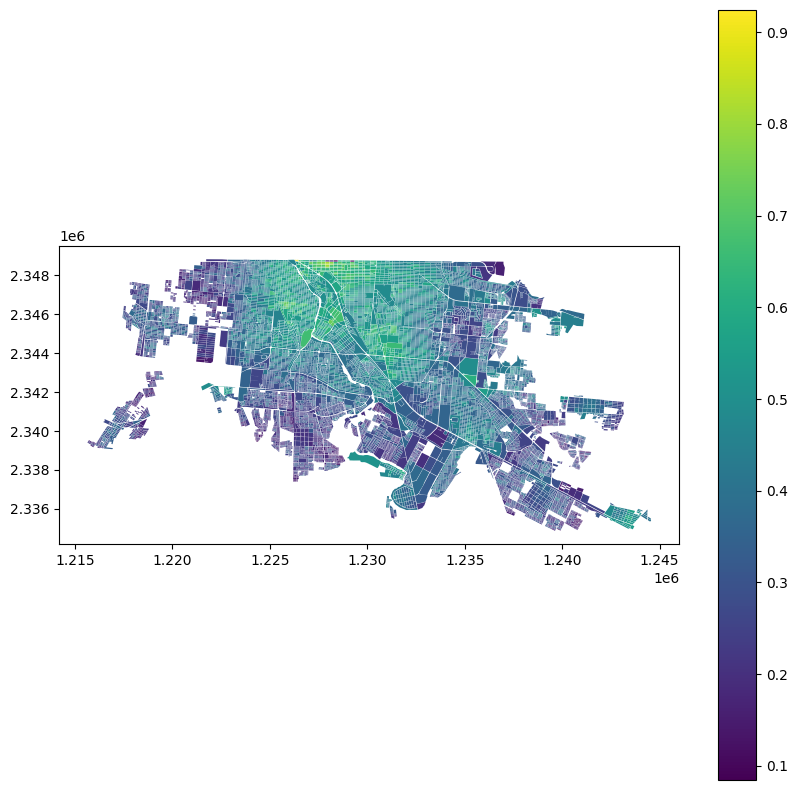

In [21]:
res_all.plot(column="accessibility_score", cmap="viridis", legend=True, figsize=(10, 10), lw=0)

In [57]:
def group_accessibility(res_df: gpd.GeoDataFrame, df_census: gpd.GeoDataFrame):
    grouped = (
        res_df[["weighted", "pobtot", "geometry"]]
        .sjoin(df_census, how="inner", predicate="within")
        .groupby("CVEGEO_right")
    )

    return grouped["weighted"].sum() / grouped["pobtot"].sum()

In [64]:
df_census["accessibility"] = group_accessibility(res_all, df_census)
df_census.to_file("./accessibility.gpkg")

In [65]:
df_census

,POBTOT,GRAPROES,frac_viv_deshab,frac_viv_inter,geometry,pop_dens,over_60_frac,accessibility
CVEGEO,,,,,,,,
0200200010019,2943.0,9.08,0.186655,0.460775,"MULTIPOLYGON (((1240836.539 2335789.786, 12408...",9905.677145,0.030921,0.214663
0200200010023,2377.0,9.31,0.252632,0.469856,"MULTIPOLYGON (((1240864.547 2335052.842, 12407...",8985.050831,0.029870,0.153156
0200200010038,6104.0,9.23,0.204130,0.291898,"MULTIPOLYGON (((1239641.963 2334838.629, 12396...",10807.998161,0.016383,0.251440
0200200010042,1293.0,9.42,0.134100,0.536398,"MULTIPOLYGON (((1225449.578 2348799.553, 12254...",2849.030438,0.227378,0.506917
0200200010057,1465.0,8.77,0.105714,0.565714,"MULTIPOLYGON (((1225449.578 2348799.553, 12257...",3287.216554,0.202730,0.548182
...,...,...,...,...,...,...,...,...
0200200018404,776.0,14.91,0.427273,0.500000,"MULTIPOLYGON (((1237755.409 2342012.264, 12378...",1572.414578,0.048969,0.349811
0200200018442,1411.0,10.55,0.071705,0.585271,"MULTIPOLYGON (((1240561.311 2339715.49, 124040...",9738.170717,0.013466,0.299293
0200200018457,406.0,11.66,0.039683,0.817460,"MULTIPOLYGON (((1239802.588 2339963.796, 12397...",10694.527738,0.007389,0.250011


<Axes: >

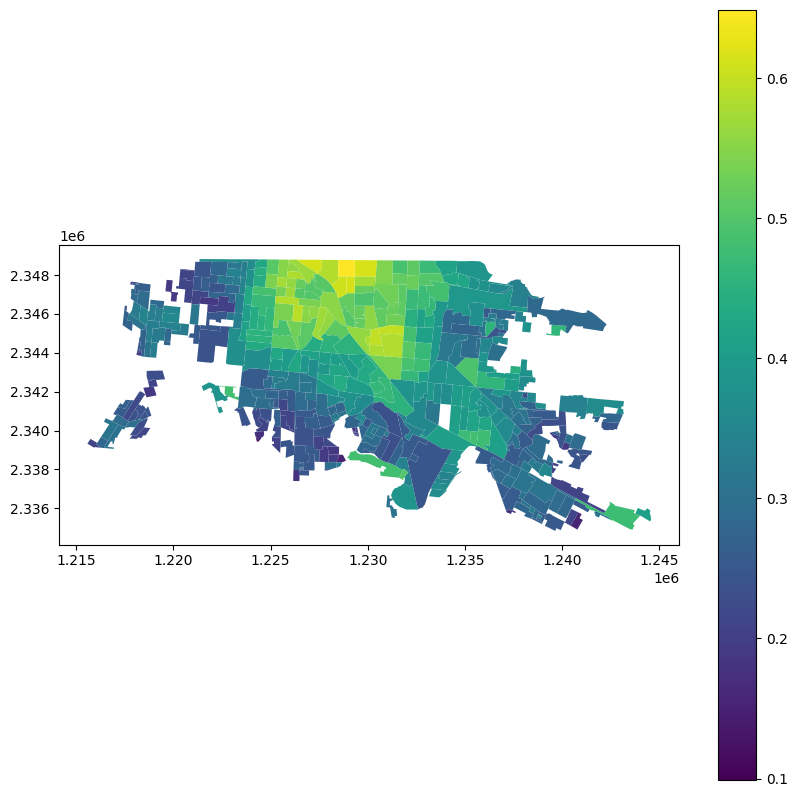

In [62]:
df_census.plot(column="accessibility", cmap="viridis", legend=True, figsize=(10, 10), lw=0)